# Data Loading

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ag-news-classification-dataset


In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import nltk
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Split train and validation set
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2'

train_file = os.path.join(dataset_path, 'train.csv')
test_file = os.path.join(dataset_path, 'test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
# Check missing value
train_df.isnull().sum()

,0
Class Index,0
Title,0
Description,0


In [ ]:
display(train_df)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


# Text Cleaning

In [ ]:
def clean_text(text):
    regex_html = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    remove_digits = str.maketrans('', '', string.digits + string.punctuation)
    text = re.sub(regex_html, '', text)
    text = text.translate(remove_digits)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

In [ ]:
train_df['text'] = (train_df.Title + " " + train_df.Description).apply(clean_text)
test_df['text'] = (test_df.Title + " " + test_df.Description).apply(clean_text)

# Label Encoding

In [ ]:
le = LabelEncoder().fit(train_df['Class Index'])
train_df['label'] = le.transform(train_df['Class Index'])
test_df['label'] = le.transform(test_df['Class Index'])

train, val = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df.label)

In [ ]:
train_df[['text', 'label']]

,text,label
0,wall st bears claw back into the black reuters...,2
1,carlyle looks toward commercial aerospace reut...,2
2,oil and economy cloud stocks outlook reuters r...,2
3,iraq halts oil exports from main southern pipe...,2
4,oil prices soar to alltime record posing new m...,2
...,...,...
119995,pakistans musharraf says wont quit as army chi...,0
119996,renteria signing a topshelf deal red sox gener...,1
119997,saban not going to dolphins yet the miami dolp...,1
119998,todays nfl games pittsburgh at ny giants time ...,1


# Tokenizing

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8192, oov_token='-')
tokenizer.fit_on_texts(train.text)

x_train = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train.text),
    maxlen=128,
    padding='post',
    truncating='post'
)
x_val = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(val.text),
    maxlen=128,
    padding='post',
    truncating='post'
)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(test_df.text),
    maxlen=128,
    padding='post',
    truncating='post'
)

y_train = train.label
y_val = val.label
y_test = test_df.label

# Model Building

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((64,)),
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index), output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(set(train_df.label)), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 64, 64)         │     5,251,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,516,292 (21.04 MB)

 Trainable params: 5,516,292 (21.04 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
    ), tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=2
    )]
)

Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.7754 - loss: 0.5395 - val_accuracy: 0.9152 - val_loss: 0.2529 - learning_rate: 0.0010
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.9237 - loss: 0.2307 - val_accuracy: 0.9168 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.9358 - loss: 0.1864 - val_accuracy: 0.9181 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.9484 - loss: 0.1462 - val_accuracy: 0.9161 - val_loss: 0.2621 - learning_rate: 0.0010
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.9560 - loss: 0.1182 - val_accuracy: 0.9167 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.9733 - loss: 0.0724 - val_accuracy: 0.9157 - val_loss: 0.3600 - learning_rate: 1.0000e-04
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - ac

Accuracy and Loss Curve

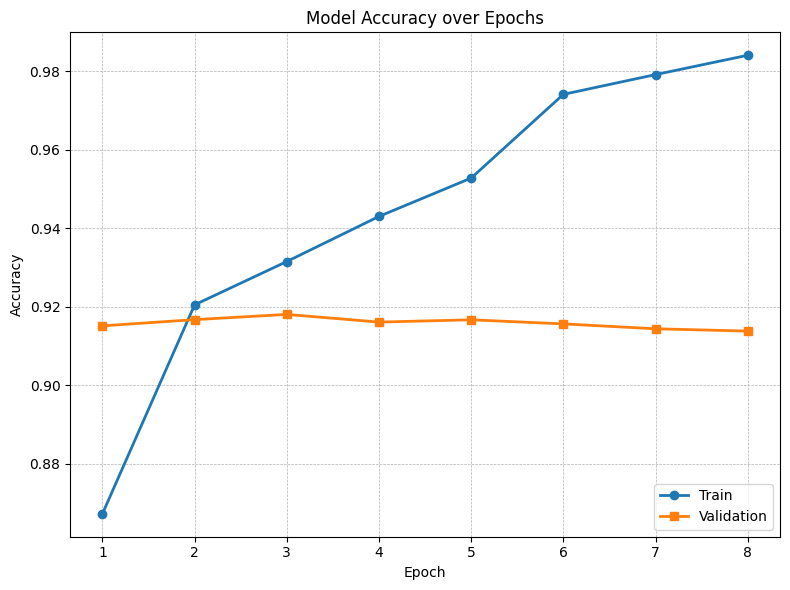

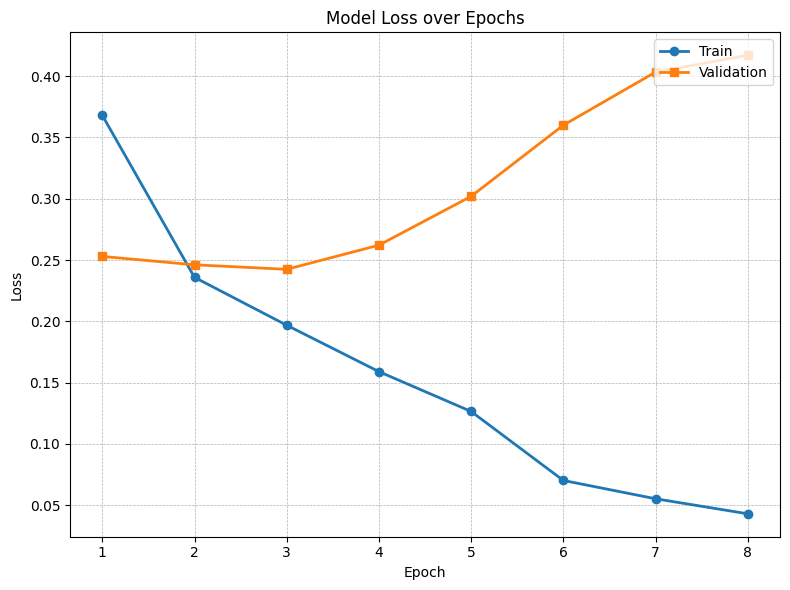

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)

# Accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['accuracy'],   marker='o', linewidth=2, label='Train')
plt.plot(epochs, history.history['val_accuracy'], marker='s', linewidth=2, label='Validation')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(" ")

# Loss curve
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['loss'],        marker='o', linewidth=2, label='Train')
plt.plot(epochs, history.history['val_loss'],    marker='s', linewidth=2, label='Validation')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Loss and Acuracy on Test Dataset

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9098 - loss: 0.2746
Test Loss: 0.25884702801704407
Test Accuracy: 0.9142104983329773


# Classification Report

In [ ]:
y_true = y_test
y_pred_probs = model(x_test)

# Predicted label
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

# Classification report
print("\nClassification report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.9142
Confusion matrix:
[[1730   49   54   67]
 [  29 1843   16   12]
 [  81    7 1654  158]
 [  49   11  119 1721]]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1900
           1       0.96      0.97      0.97      1900
           2       0.90      0.87      0.88      1900
           3       0.88      0.91      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

